# Домашняя работа 9. Работа с текстами.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.
4. Пришлите на почту ml-teachers ссылку на этот файл в вашем репозитории.
5. В теме письма указать `ML Homework #12: Name Surname`. Если тема будет неправильная, то задание не будет проверено.
6. Дедлайн: (14.03.2018 23:59)
7. После дедлайна можно сдать, но вы получите штраф по баллам в рейтинге.

Рассылка решений: 19.03.2018 17:00  
После рассылки задания почти совсем не имеют веса.

## Полезная литература

- [Word2vec notebook example](https://github.com/RaRe-Technologies/movie-plots-by-genre)
- [Sklearn text classification example](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

В этот раз мы будем работать с датасетом, содержащим обзоры на вина с сайта [winemag.com](https://www.winemag.com/). Сам датасет лежит на [kaggle/wine-reviews](https://www.kaggle.com/zynicide/wine-reviews/data). Скачайте файл `winemag-data-130k-v2.csv.zip`.

Будем предсказывать `points` для вина по описанию. К сожалению у нас нет возможности предсказывать цену и качество конткретного вина, так как все отзывы про разные вина. Но можно предсказывать вид: `variety` (708 категорий).

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from nltk import download
# возможно вам подребуется загрузить что-то еще >_<
download('wordnet')
download('averaged_perceptron_tagger')
download('tagsets')
download('punkt')
download('stopwords')

%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zeus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\zeus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\zeus\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zeus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zeus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 0. Подготовка данных

Данных очень много и в них есть пропуски. Поэтому мы просто удаляем все объекты с пропущенными значениями.

### Чтение данных

- Скачайте датасет `winemag-data-130k-v2.csv.zip` с [kaggle/wine-reviews](https://www.kaggle.com/zynicide/wine-reviews/data). 
- выполните все следующие ячейки

In [3]:
df_raw = pd.read_csv('./../../data/winemag-data-130k-v2.csv.zip', index_col=0, compression='zip')
print(df_raw.shape)
df_raw.head()

(129971, 13)


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
df_raw.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [5]:
df = df_raw.dropna(subset=['points', 'price'], how='any').copy()

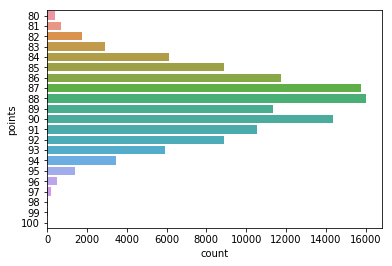

In [6]:
sns.countplot(y='points', data=df);

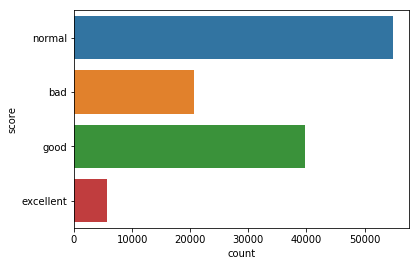

In [7]:
df.loc[(df['points'] < 86), 'score'] = 'bad'
df.loc[(df['points'] >= 86) & (df['points'] < 90), 'score'] = 'normal'
df.loc[(df['points'] >= 90) & (df['points'] < 94), 'score'] = 'good'
df.loc[df['points'] >= 94, 'score'] = 'excellent'

sns.countplot(y='score', data=df);

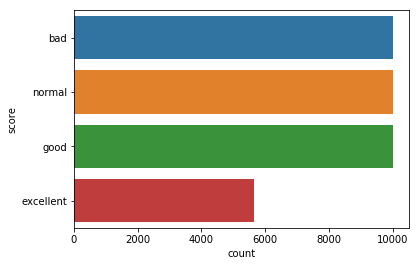

In [8]:
N = 10000  # уменьшаем датасет

df_small = pd.concat((df[df['score'] == 'bad'].head(N),
df[df['score'] == 'normal'].head(N),
df[df['score'] == 'good'].head(N),
df[df['score'] == 'excellent'].head(N)))

sns.countplot(y='score', data=df_small);

In [9]:
# посмотрим пример
df_small[df_small['score'] == 'excellent'].sample()['description'].values[0]

"DVX is Mumm Napa's top of the line vintage bottling. This '02 is a 50-50 blend of Pinot Noir and Chardonnay, making it a brut. It's very high in acidity, and the bubbles are tiny and refined, giving it the ultra-smooth mouthfeel you want in a superior sparkling wine. The raspberry, lime and pear flavors are rich, but subtle, reined in by yeastiness and a tangy minerality. Drink this luxurious bubbly now and over the next 10 years."

In [10]:
X = df_small['description']
y = df_small['score']

## 1. Препроцессинг текстов

В этом блоке заданий вам предстоит зяняться препроцессиногом текстов.
Самое главное в работе с текстами - их препроцессинг. При этом важно понимать, для какой модели мы "готовим" наш текст. Например, если мы используем просто [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), то нам не важно расположение слова в тексте и мы **должны** привести все слова к нижнему (или верхнему) регистру. Но при этом, если мы используем какую-нибудь модель, которая первое слово в тексте (или имена собственные) оценивает как-нибудь по другому, то стоит оставить такие заглавные буквы.

### 1.2 Простая обработка данных
В данном задании вам нужно написать функцию, разбивающую текст на слова, при этом удаляя слова короче 2 символов.
Приведение к нижнему регистру и удаление стоп слов будет сделано с помощью аргументов конструктора конкретного векторайзера. Так работает намного быстрее.

**Hint:** используйте функцию `word_tokenize` и список стоп-слов из библиотеки nltk

In [11]:
from nltk.corpus import stopwords
from nltk import word_tokenize

def simple_tokenize_text(text: str) -> list:
    tokens = [token for token in word_tokenize(text) if token not in stopwords.words('english') and len(token) > 2]
    return tokens

Покажите, что станет с этим текстом, пропустив его через токенайзер: `"The quick brown fox jumps over the lazy dogs. Have you seen it?"`

In [12]:
%%time
simple_tokenize_text("The quick brown fox jumps over the lazy dogs. Have you seen it?")

Wall time: 75.1 ms


['The', 'quick', 'brown', 'fox', 'jumps', 'lazy', 'dogs', 'Have', 'seen']

### 1.3 Стемминг текстов

Стемминг - процесс отбрасывания от слов "ненужных" частей, то есть по-сути выделение основы из слова. При этом результат стемминга может не совпадать с морфологической основой или корнем. Существует достаточно много алгоритмов стемминга. Мы рассмотрим 3 из них: (добавить Snowball Stemmer Lancaster Stemmer)

Ниже предствлены примеры работы `PorterStemmer` стеммера:

In [13]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

print(stemmer.stem('hello'))
print(stemmer.stem('cook'))
print(stemmer.stem('cooker'))
print(stemmer.stem('cooked'))
print(stemmer.stem('multiply'))

hello
cook
cooker
cook
multipli


### 1.3.0

Дополните функцию `simple_tokenize_text` стеммингом слов с помощью стеммера `PorterStemmer` из библиотеки nltk.

In [14]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def stem_tokenize_text(text: str) -> list:
    return [stemmer.stem(token) for token in simple_tokenize_text(text)]

Покажите, что станет с этим текстом, пропустив его через токенайзер: `"The quick brown fox jumps over the lazy dogs. Have you seen it?"`

In [15]:
%%time
stem_tokenize_text("The quick brown fox jumps over the lazy dogs. Have you seen it?")

Wall time: 25 ms


['the', 'quick', 'brown', 'fox', 'jump', 'lazi', 'dog', 'have', 'seen']

### 1.3.1
Подберите 3 слова на английском языке, разные времена которых будут иметь разные варианты после `PorterStemmer` стемминга. То есть стемминг не будет иметь на них эффекта. Выведите результат стемминга данных слов

In [16]:
print(stemmer.stem("is"))
print(stemmer.stem("was"))
print(stemmer.stem("will"))
print('-=-=-=-=-=-=-=-=-=-=-=')
print(stemmer.stem("cleave"))
print(stemmer.stem("cleft"))
print(stemmer.stem("cloven"))
print('-=-=-=-=-=-=-=-=-=-=-=')
print(stemmer.stem("go"))
print(stemmer.stem("went"))
print(stemmer.stem("gone"))

is
wa
will
-=-=-=-=-=-=-=-=-=-=-=
cleav
cleft
cloven
-=-=-=-=-=-=-=-=-=-=-=
go
went
gone


Подобные "проблеммы" есть почти у всех видов стеммеров. Лемматизаторы позволяют избежать данных проблем. Лемматизация сильно похожа на стемминг, но отличаются они лишь тем, что стемминг смотрит только на слово, не учитывая контекст.

Рассмотрим примеры работы лемматизатора:

In [17]:
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
print(wordnet_lemmatizer.lemmatize('are'))
print(wordnet_lemmatizer.lemmatize('is'))

are
is


Как мы видим, `are` и `is` не превратились в начальную форму. Все из-за того, что лемматизатор не знал, к какой части речи отнести данные слова. но если мы скажем, тогда:

In [18]:
print(wordnet_lemmatizer.lemmatize('are', pos='v'))
print(wordnet_lemmatizer.lemmatize('is', pos='v'))

be
be


Так как для работы лемматизатора нам необходимы части речи, нужно научиться эти самые части речи определять. Это задача POS-tagging (POST). Рассмотрим работу POS-тэггера из библиотеки nltk:

In [19]:
from nltk import pos_tag, word_tokenize

posed_words = pos_tag(word_tokenize('We love our students'))
print(posed_words)

[('We', 'PRP'), ('love', 'VBP'), ('our', 'PRP$'), ('students', 'NNS')]


Но что же значат эти теги? Давайте разберемся!

In [20]:
from nltk.help import upenn_tagset

print(upenn_tagset('PRP'))
print(upenn_tagset('VBP'))

PRP: pronoun, personal
    hers herself him himself hisself it itself me myself one oneself ours
    ourselves ownself self she thee theirs them themselves they thou thy us
None
VBP: verb, present tense, not 3rd person singular
    predominate wrap resort sue twist spill cure lengthen brush terminate
    appear tend stray glisten obtain comprise detest tease attract
    emphasize mold postpone sever return wag ...
None


Для того, чтобы объеденить лемматизатор и POS тэггер, нам потребуется промежуточная функция:

In [21]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    if treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [22]:
wordnet_lemmatizer.lemmatize(posed_words[3][0], pos=get_wordnet_pos(posed_words[3][1]))

'student'

### 1.3.2

Улучшим функцию `simple_tokenize_text`: добавим лемматизацию слов.

In [23]:
def lemm_tokenize_text(text: str) -> list:
    return [wordnet_lemmatizer.lemmatize(tupl[0], pos=get_wordnet_pos(tupl[1])) for tupl in pos_tag(simple_tokenize_text(text))]

Покажите, что станет с этим текстом, пропустив его через токенайзер: `"The quick brown fox jumps over the lazy dogs. Have you seen it?"`

In [24]:
%%time
lemm_tokenize_text("The quick brown fox jumps over the lazy dogs. Have you seen it?")

Wall time: 40 ms


['The', 'quick', 'brown', 'fox', 'jump', 'lazy', 'dog', 'Have', 'see']

У нас получилось 3 способа токенизации. Будем использовать их в будующих заданиях.

In [25]:
tokenizers = [
    simple_tokenize_text,
    stem_tokenize_text,
    lemm_tokenize_text
]

In [26]:
# Это код из практики для красивого вывода
from sklearn.metrics import confusion_matrix

def examine(clf, X_train, X_test, y_train, y_test, scoring='accuracy', my_tags=['bad', 'normal', 'good', 'excellent']):
    clf.fit(X_train, y_train)
    scores = clf.score(X_test, y_test)
    sns.heatmap(confusion_matrix(y_test, clf.predict(X_test)), xticklabels=my_tags, yticklabels=my_tags, annot=True, fmt="d",cmap=plt.cm.Blues)
    plt.show()
    print('%s1 : %s2' % (clf.__class__.__name__, scores))
    return {'score': scores, 'clf': clf.__class__.__name__}

# 2. Эксперименты с векторайзерами

У нас есть несколько моделей токенайзеров, теперь можно посмотреть как каждый из них работает с разными векторайзерами: `CountVectorizer`, `TfidfVectorizer`. Вы увидите, что даже от предобработки признаков зависит много, не меньше чем от дальнейшей векторизайии. 

Будем сравнивать качество классификации обычным `RidgeClassifier`, перебирая разные векторайзеры и токенайзеры. Наиболее интересно, рассматривать confusion matrix, как мы делали на практике. Поэтому используйте функцию `examine`. Добавляйте в начало ячейки макрос `%%time`, чтобы видеть как долго работает обучение, трансформации и токенизации.

В практике мы дополнительно выводили список наиболее важных слов по мнению классификатора при принятии решений. Вы тоже должны вывести список 10 самых важных слов для каждого класса для каждого эксперимента. Это даже важнее, чем просто процент ошибок, так как по этим словам вы можете сказать, есть ли у модели хоть какое-то понимание текстов или нет.

### Задание:

- перебор `simple_tokenize_text`, `stem_tokenize_text`, `lemm_tokenize_text`
- перебор `CountVectorizer`, `TfidfVectorizer`
- используем `RidgeClassifier`
- разбиваем выборку на тестовую и тренировочную в соотношении 60/40 с random_state=42 (train_test_split)
- рисуем confusion_matrix
- выводим топ-10 наиболее важных слов по категориям

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from tqdm import tqdm

In [32]:
X.apply(simple_tokenize_text)

KeyboardInterrupt: 

In [29]:
y = df_small['score']
for tokenizer in tqdm(tokenizers):
    X = df_small['description'].apply(tokenizer)
    print(X.head(1))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)
    for vectorizer in tqdm([CountVectorizer, TfidfVectorizer]):
        vectorizer = vectorizer().fit(X)
        for classifier in tqdm([RidgeClassifier, ExtraTreesClassifier]):
            print(examine(classifier, X_train, X_test, y_train, y_test))


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]
Exception in thread Thread-6:
Traceback (most recent call last):
  File "A:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "A:\ProgramData\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "A:\ProgramData\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




KeyboardInterrupt: 

Выведите размер полученного словаря

Покажите наиболее важные слова для модели

In [ ]:
show_most_influential_words(clf, cv)

## TF-IDF

# 3. Эксперименты с word2vec

На практике мы рассмотрели продвинутую технологию анализа текстов: word2vec и doc2vec. Дополнительно про них вы можете посмотреть на видео: 

- [Мастер класс](https://www.youtube.com/watch?v=oBb9aFmp0Hs) по Gensim и [исходники](https://github.com/RaRe-Technologies/movie-plots-by-genre)
- [Лекция](https://www.youtube.com/watch?v=hiDBnEyoZS4) по векторным представления слов в документах.

### Задание

- скачать предобученный word2vec [Google News pre-trained word2vec (1.5 GB)](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)
- установить gensim
- получите векторное представление текстов, применив токенайзер с лемматизацией. В качестве вектора текста будем использовать средний вектор всех слов текста. Это было описано в практике.
- обучите RidgeClassifier
- постройте confusion matrix
- выведите наиболее близкие в векторном смысле слова к среднему вектору темы (это тоже было)

# 4. Doc2Vec

Теперь обучаем doc2vec модель. Посмотрите сами сколько нужно выбрать итераций, чтобы получилось более менее приемлемое качество. В этот раз у нас данных достаточно много, но мы ограничены производительностю компьютера. 

Основная цель этого экспериента - получить сравнение близости тем(тэгов doc2vec) друг относительно друга, как мы делали с жанрами фильмов. Мы надеемся что комментарии про отличное вино сильно не похожи на комментарии про отвратительное. А может нет, doc2vec его знает. 

# 5. Ансамбль

С помощью `Pipeline` объедините модели с лучшими результатами и тоже постройте `confusion matrix`.

# на подумать

Если наша цель построить действительно мощный предсказатель. То нам стоит учитывать числа в текстах. Обычно их просто заменяют на символы `#`, но в данном случае они имеют значение. Возможно их стоит рассматривать как отдельные числовые признаки. Вполне возможно в тексте будет много имен собственных, их тоже можно обрабатывать отдельно.

Если вам будет интересна тема обработки текстов, то на kaggle есть соревнования: 

- https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
- https://www.kaggle.com/c/quora-question-pairs
- https://www.kaggle.com/c/spooky-author-identification/

Дополнительно можете почитать про [Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit).